In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf, validate_on
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
import numpy as np
LEARNING_RATE = 0.0001

0.90 - For proving that using pre-trained model works better

In [2]:
# train_ds, val_ds, label_names = dataset_tf("./dataset/sbcm_hive_1_train_copy", 0.30, 16)
# train_ds, val_ds, label_names = dataset_tf("./dataset/pitched_transformed_train", 0.50, 16)
train_ds, val_ds, label_names = dataset_tf("dataset/osbh_sep_1", 0.80, 8)

Found 130 files belonging to 2 classes.
Using 104 files for training.
Using 26 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (8, 4000)
Example label shape: (8,)
513 44100


2024-03-31 17:34:46.079403: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-31 17:34:46.079435: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-31 17:34:46.079443: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-31 17:34:46.079478: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-31 17:34:46.079494: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [3]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Train raw models

## Raw - MFCCs

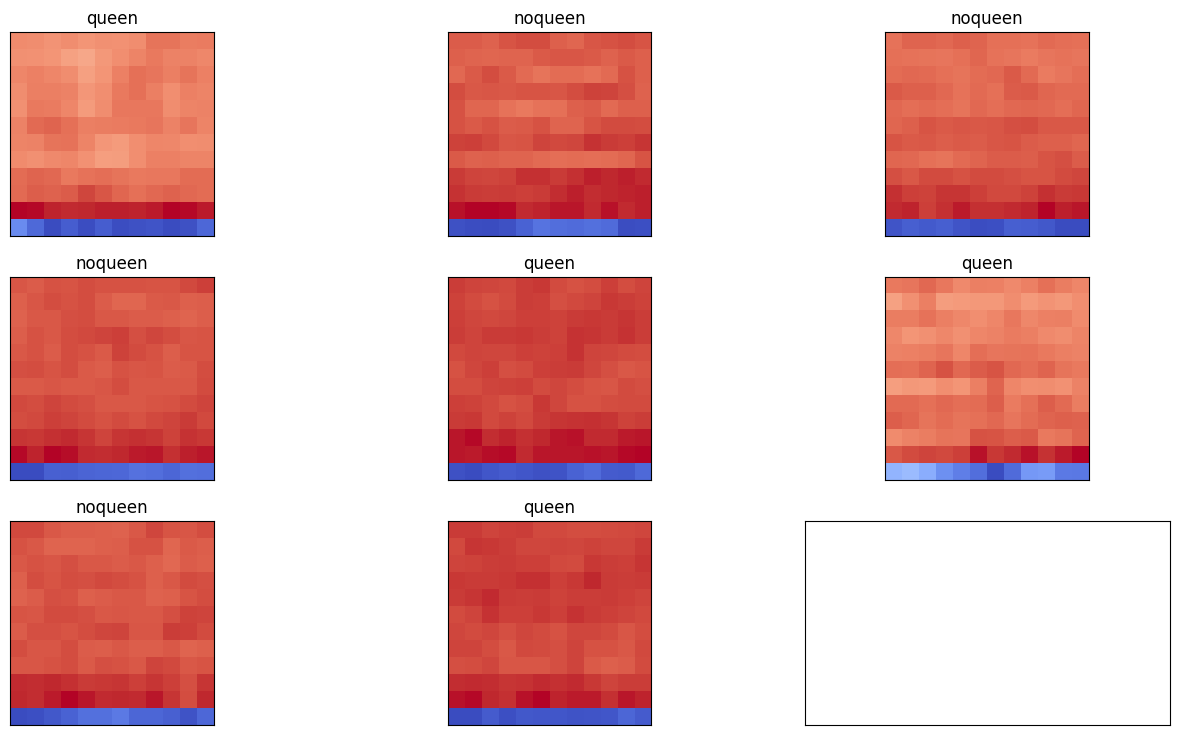

In [4]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [5]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
input_shape

TensorShape([12, 12, 1])

In [6]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [MFCCs] Sequential Model

2024-03-31 17:34:47.388933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10
 1/13 [=>............................] - ETA: 5s - loss: 0.7678 - accuracy: 0.3750

2024-03-31 17:34:47.931890: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


13/13 [==============================] - 1s 33ms/step - loss: 0.7284 - accuracy: 0.5192 - val_loss: 0.6506 - val_accuracy: 0.6923
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 0.6758 - accuracy: 0.5865 - val_loss: 0.6341 - val_accuracy: 0.6923
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 0.6404 - accuracy: 0.6635 - val_loss: 0.6041 - val_accuracy: 0.6923
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 0.6121 - accuracy: 0.6346 - val_loss: 0.5791 - val_accuracy: 0.6923
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 0.5719 - accuracy: 0.7212 - val_loss: 0.5413 - val_accuracy: 0.6923
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 0.5390 - accuracy: 0.7788 - val_loss: 0.5127 - val_accuracy: 0.9615
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 0.4971 - accuracy: 0.7596 - val_loss: 0.4515 - val_accuracy: 0.8462
Epoch 8/10
13/13 [======

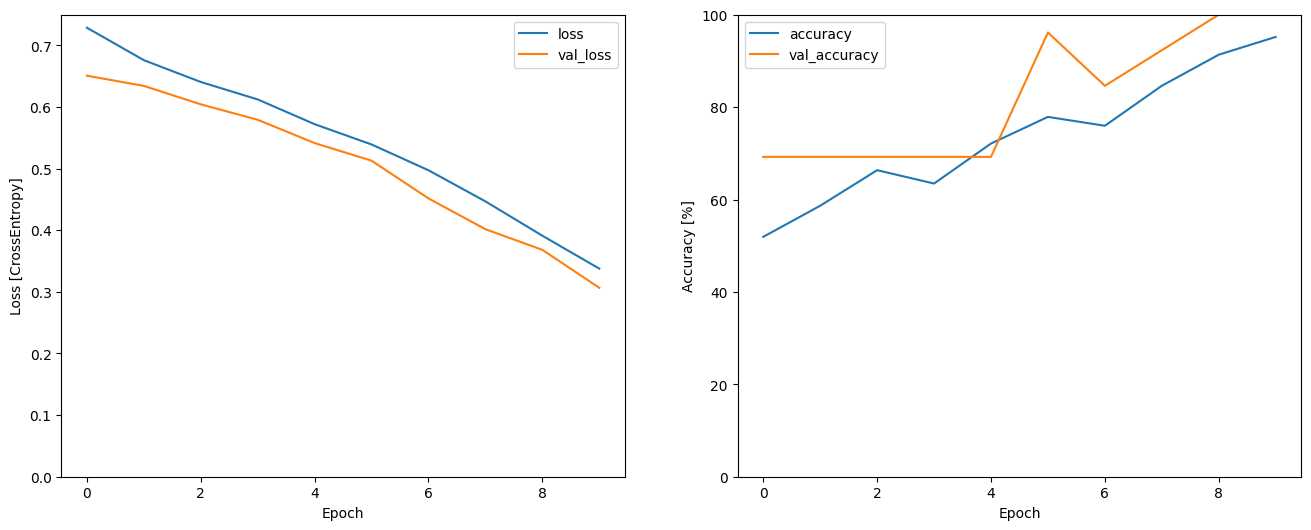

In [7]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=10,
    # callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [Reinf:Raw] [MFCCs] Convolutional Model (mini)

Epoch 1/10
13/13 [==============================] - 0s 17ms/step - loss: 1.6732 - accuracy: 0.4423 - val_loss: 1.6457 - val_accuracy: 0.3077
Epoch 2/10
13/13 [==============================] - 0s 6ms/step - loss: 1.2502 - accuracy: 0.4423 - val_loss: 1.1938 - val_accuracy: 0.3077
Epoch 3/10
13/13 [==============================] - 0s 6ms/step - loss: 0.9227 - accuracy: 0.4423 - val_loss: 0.8889 - val_accuracy: 0.3077
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 0.7630 - accuracy: 0.5577 - val_loss: 0.7316 - val_accuracy: 0.5769
Epoch 5/10
13/13 [==============================] - 0s 5ms/step - loss: 0.7141 - accuracy: 0.4615 - val_loss: 0.6698 - val_accuracy: 0.6154
Epoch 6/10
13/13 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.4808 - val_loss: 0.6405 - val_accuracy: 0.6923
Epoch 7/10
13/13 [==============================] - 0s 5ms/step - loss: 0.6651 - accuracy: 0.5769 - val_loss: 0.6281 - val_accuracy: 0.7692
Epoch 8/10
13/13 [=

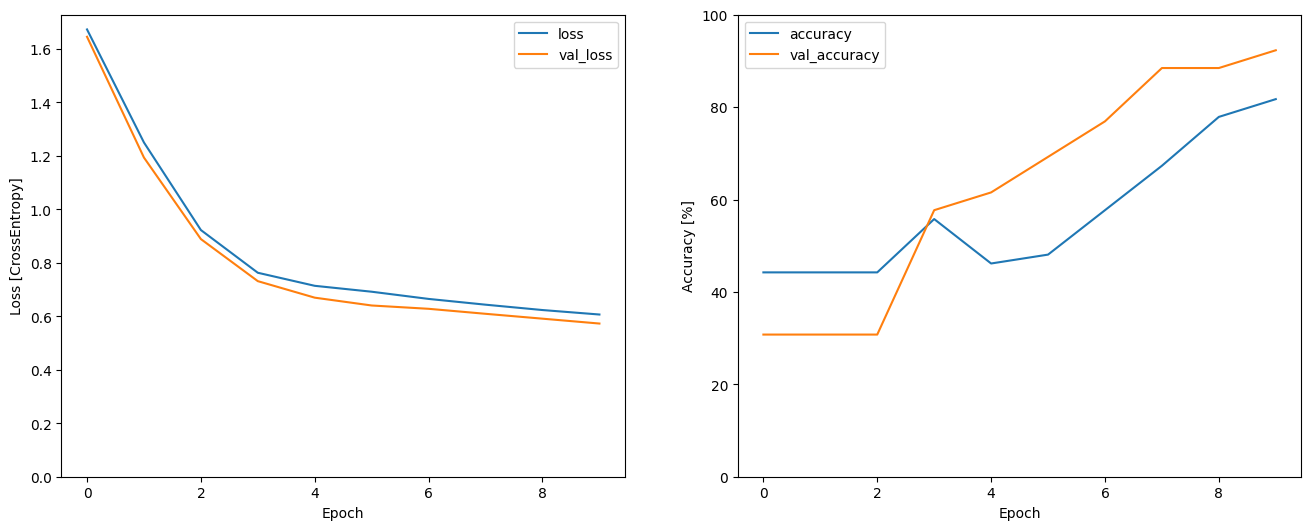

In [8]:
model_mfcc_conv = get_conv_model_mini(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Raw - Spectrograms

(118, 129, 1)


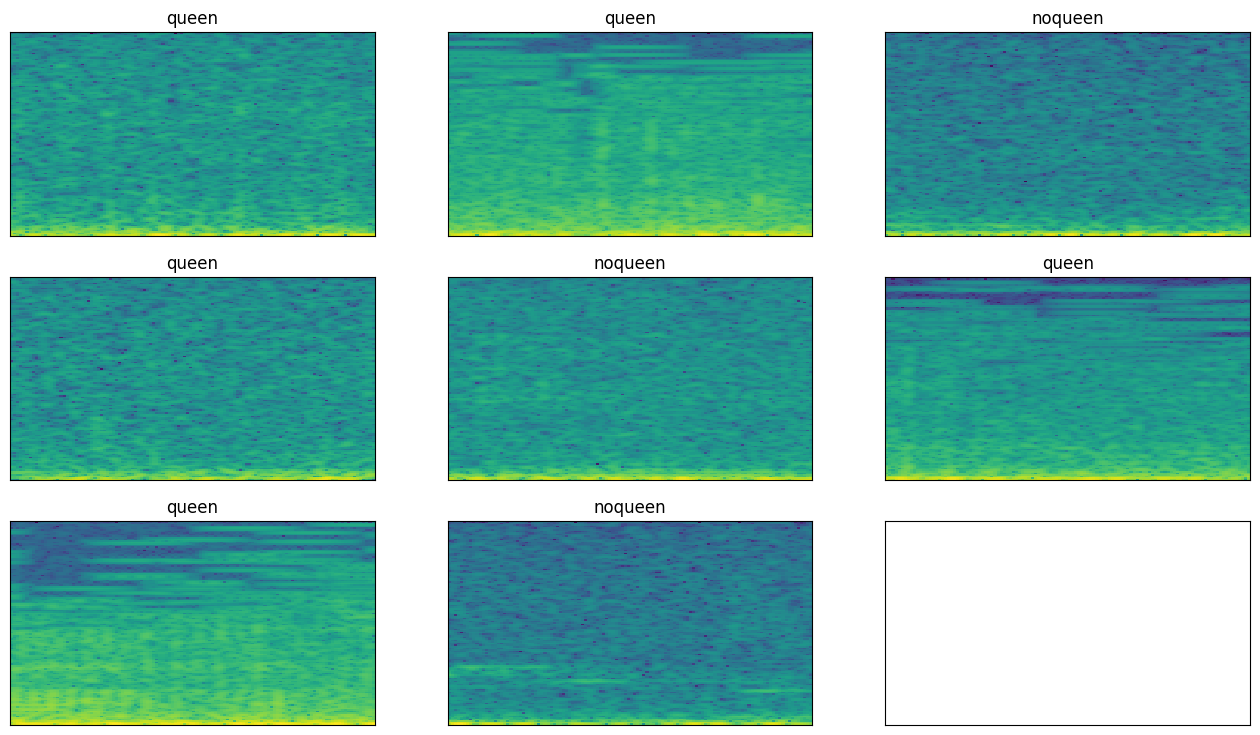

In [9]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [10]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [Spec] Sequential model

Epoch 1/10
13/13 [==============================] - 1s 24ms/step - loss: 0.6829 - accuracy: 0.5673 - val_loss: 0.6176 - val_accuracy: 0.6923
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 0.6427 - accuracy: 0.5769 - val_loss: 0.5886 - val_accuracy: 0.6923
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 0.6085 - accuracy: 0.6827 - val_loss: 0.5777 - val_accuracy: 0.6923
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 0.5799 - accuracy: 0.6923 - val_loss: 0.5699 - val_accuracy: 0.6923
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 0.5455 - accuracy: 0.6538 - val_loss: 0.5478 - val_accuracy: 0.3462
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 0.5131 - accuracy: 0.7212 - val_loss: 0.5416 - val_accuracy: 0.5385
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 0.4943 - accuracy: 0.7404 - val_loss: 0.5257 - val_accuracy: 0.5385
Epoch 8/10
13

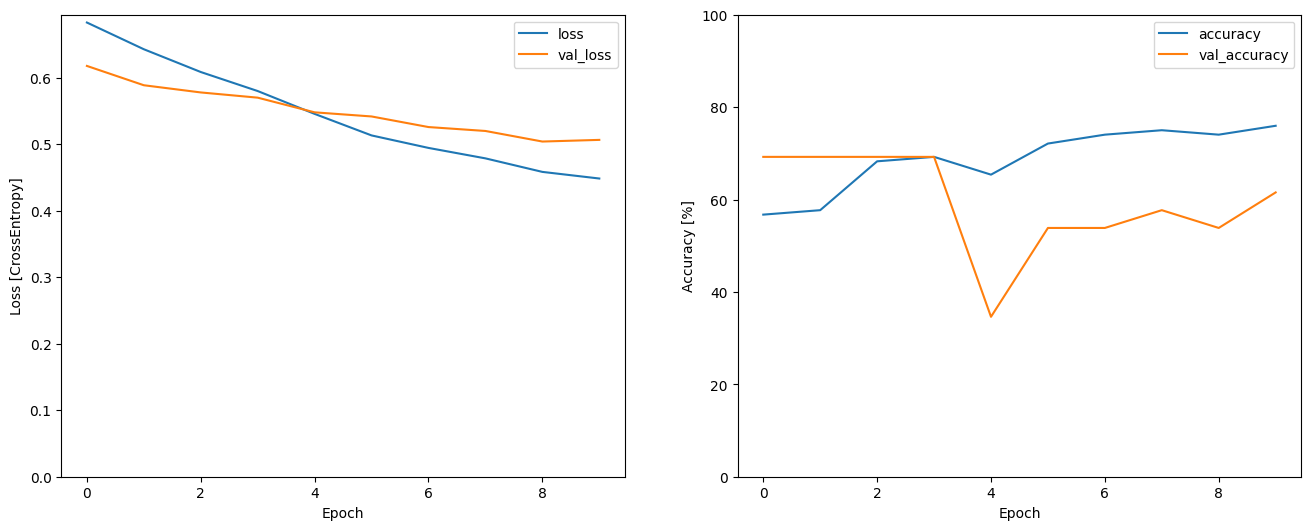

In [11]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=10,
    # callbacks=callbacks
)
plot_history(history_spec_seq)

### [Reinf:Raw] [Spec] Convolutional model

Epoch 1/10
13/13 [==============================] - 1s 21ms/step - loss: 0.6769 - accuracy: 0.5385 - val_loss: 0.6021 - val_accuracy: 0.6923
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 0.6532 - accuracy: 0.5577 - val_loss: 0.5915 - val_accuracy: 0.6923
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 0.6342 - accuracy: 0.5577 - val_loss: 0.5678 - val_accuracy: 0.6923
Epoch 4/10
13/13 [==============================] - 0s 12ms/step - loss: 0.6121 - accuracy: 0.5577 - val_loss: 0.5452 - val_accuracy: 0.6923
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 0.5875 - accuracy: 0.5385 - val_loss: 0.5298 - val_accuracy: 0.4615
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 0.5646 - accuracy: 0.5769 - val_loss: 0.5124 - val_accuracy: 0.5385
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 0.5384 - accuracy: 0.6442 - val_loss: 0.5034 - val_accuracy: 0.5769
Epoch 8/10
13

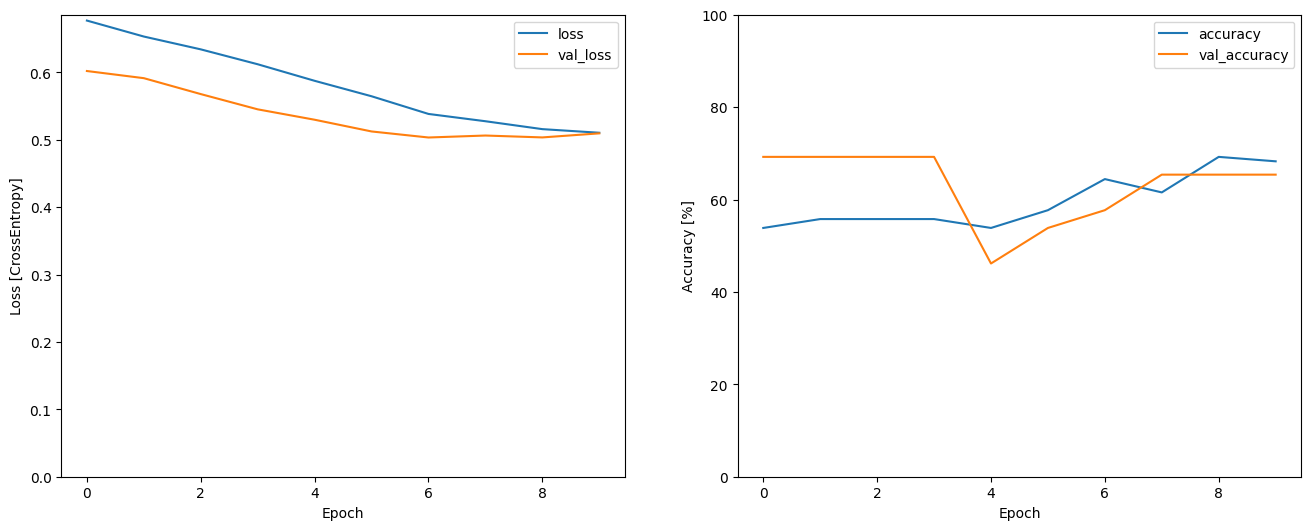

In [12]:
model_spec_conv = get_conv_model(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(history_spec_conv)

# Pre-trained models

In [13]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")
trained_model_spec_seq = tf.keras.models.load_model("models/spec_seq.h5")
trained_model_spec_conv = tf.keras.models.load_model("models/spec_conv.h5")

In [14]:
results = trained_model_mfcc_seq.evaluate(val_mfccs_ds)
print(f"MFCC Seq: {results}")
results = trained_model_mfcc_conv.evaluate(val_mfccs_ds)
print(f"MFCC Conv: {results}")
results = trained_model_spec_seq.evaluate(val_spectrogram_ds)
print(f"Spec Seq: {results}")
results = trained_model_spec_conv.evaluate(val_spectrogram_ds)
print(f"Spec Conv: {results}")

4/4 [==============================] - 0s 15ms/step - loss: 2.7071 - accuracy: 0.2692
MFCC Seq: [2.707073450088501, 0.26923078298568726]
4/4 [==============================] - 0s 12ms/step - loss: 1.4196 - accuracy: 0.2692
MFCC Conv: [1.4195845127105713, 0.26923078298568726]
4/4 [==============================] - 0s 15ms/step - loss: 1.6904 - accuracy: 0.3077
Spec Seq: [1.69038724899292, 0.3076923191547394]
4/4 [==============================] - 0s 14ms/step - loss: 2.4877 - accuracy: 0.3077
Spec Conv: [2.4877431392669678, 0.3076923191547394]


### [Reinf] [MFCCs] Sequential model

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 2.1096 - accuracy: 0.4327 - val_loss: 1.1556 - val_accuracy: 0.5000
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 0.9973 - accuracy: 0.6250 - val_loss: 0.5586 - val_accuracy: 0.7308
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 0.5782 - accuracy: 0.7596 - val_loss: 0.6608 - val_accuracy: 0.6923
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 0.3563 - accuracy: 0.8462 - val_loss: 0.4823 - val_accuracy: 0.7692
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 0.2830 - accuracy: 0.8846 - val_loss: 0.4726 - val_accuracy: 0.7692
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 0.2377 - accuracy: 0.9231 - val_loss: 0.4077 - val_accuracy: 0.8077
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 0.2039 - accuracy: 0.9327 - val_loss: 0.3868 - val_accuracy: 0.8077
Epoch 8/10
13

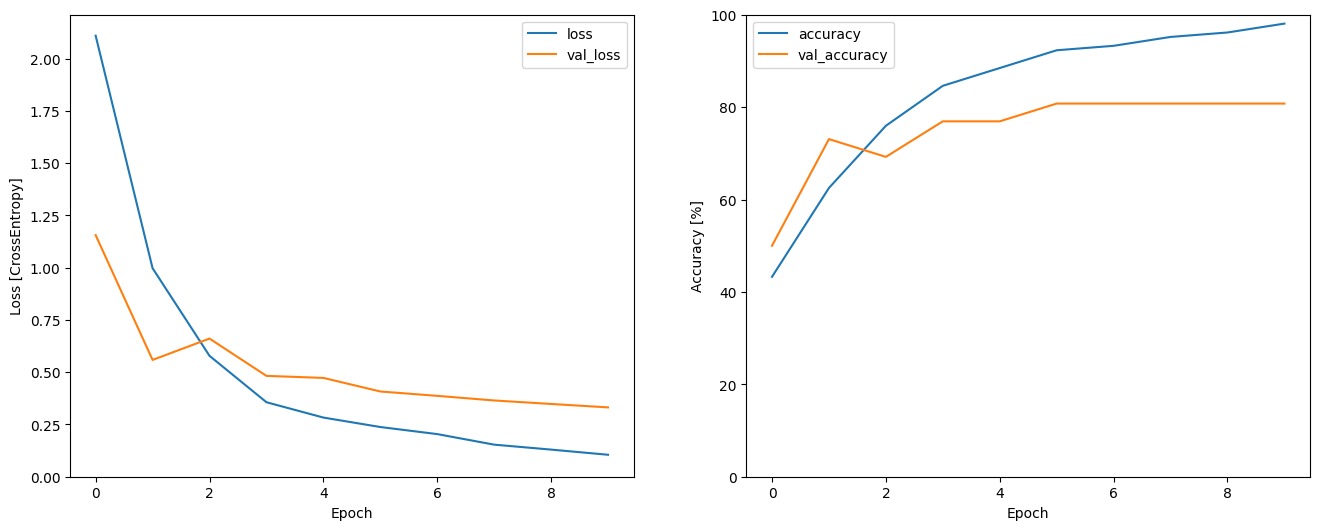

In [15]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

### [Reinf] [MFCCs] Convolutional model (mini)

Epoch 1/10
13/13 [==============================] - 0s 7ms/step - loss: 1.0169 - accuracy: 0.4615 - val_loss: 0.8222 - val_accuracy: 0.6923
Epoch 2/10
13/13 [==============================] - 0s 6ms/step - loss: 0.7449 - accuracy: 0.6538 - val_loss: 0.6885 - val_accuracy: 0.6923
Epoch 3/10
13/13 [==============================] - 0s 6ms/step - loss: 0.6366 - accuracy: 0.7115 - val_loss: 0.6028 - val_accuracy: 0.7308
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 0.5604 - accuracy: 0.7596 - val_loss: 0.5609 - val_accuracy: 0.7308
Epoch 5/10
13/13 [==============================] - 0s 6ms/step - loss: 0.5099 - accuracy: 0.7885 - val_loss: 0.5017 - val_accuracy: 0.8077
Epoch 6/10
13/13 [==============================] - 0s 6ms/step - loss: 0.4905 - accuracy: 0.7885 - val_loss: 0.4835 - val_accuracy: 0.7692
Epoch 7/10
13/13 [==============================] - 0s 6ms/step - loss: 0.4596 - accuracy: 0.8173 - val_loss: 0.4677 - val_accuracy: 0.7692
Epoch 8/10
13/13 [==

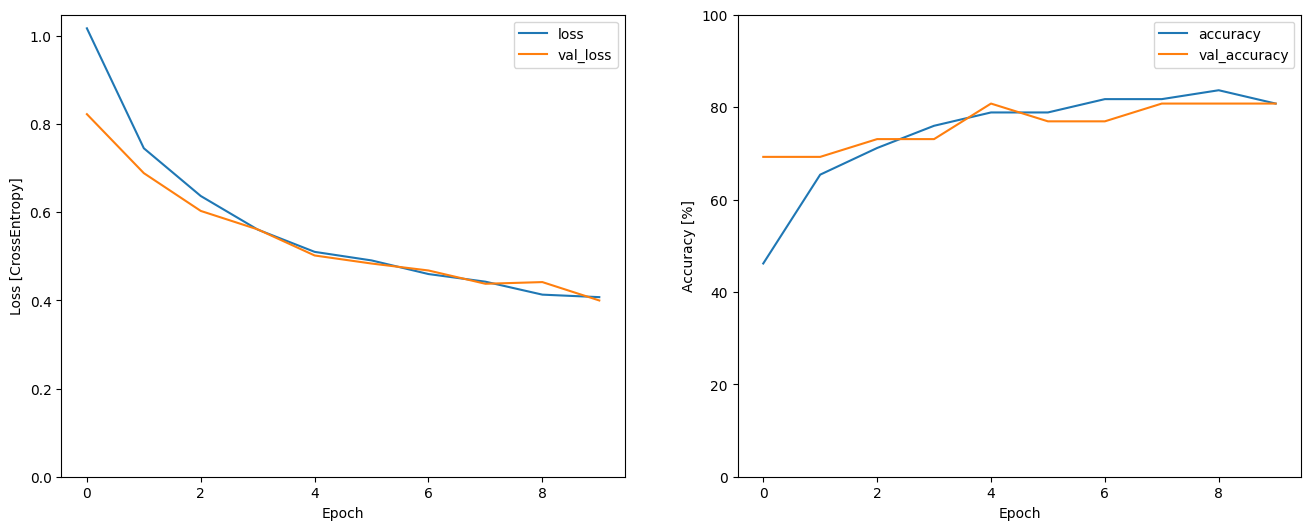

In [16]:
trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

### [Reinf] [Spec] Sequential model

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 0.9999 - accuracy: 0.5481 - val_loss: 0.7077 - val_accuracy: 0.6923
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 0.8439 - accuracy: 0.5577 - val_loss: 0.8650 - val_accuracy: 0.6538
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 0.5875 - accuracy: 0.6827 - val_loss: 0.5265 - val_accuracy: 0.5385
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 0.4970 - accuracy: 0.7500 - val_loss: 0.5710 - val_accuracy: 0.6154
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 0.4895 - accuracy: 0.7596 - val_loss: 0.5547 - val_accuracy: 0.6154
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 0.4831 - accuracy: 0.7500 - val_loss: 0.5664 - val_accuracy: 0.6154
Epoch 7/10
13/13 [==============================] - 0s 11ms/step - loss: 0.4765 - accuracy: 0.7404 - val_loss: 0.5493 - val_accuracy: 0.6154
Epoch 8/10
13

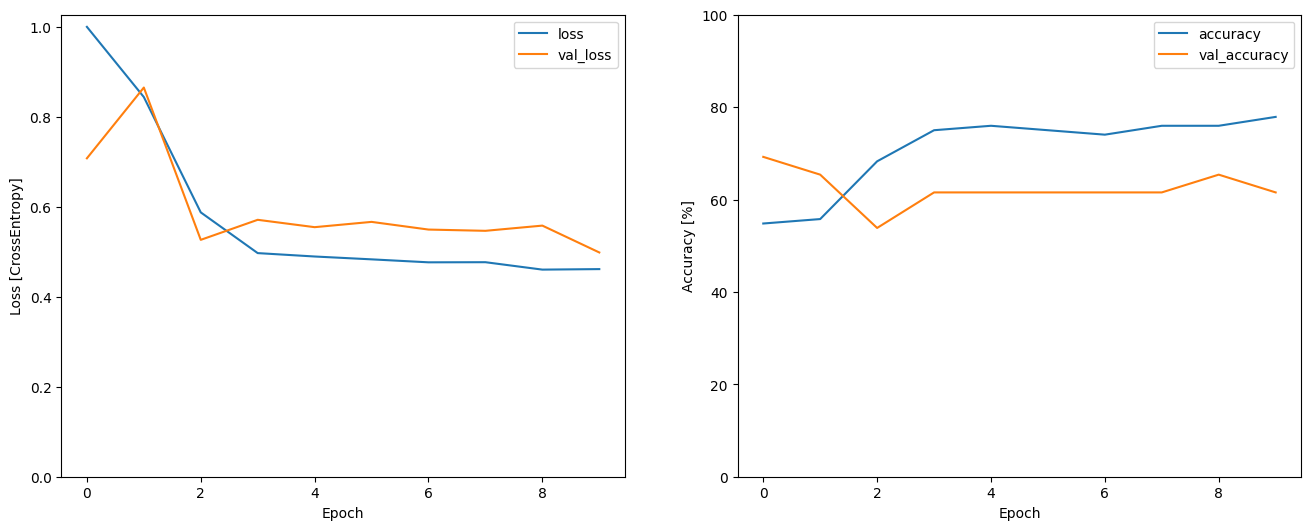

In [17]:
trained_history_spec_seq = trained_model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_spec_seq)

### [Reinf] [Spec] Convolutional model

Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 1.1788 - accuracy: 0.5000 - val_loss: 0.7005 - val_accuracy: 0.6923
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 0.7078 - accuracy: 0.5769 - val_loss: 0.5548 - val_accuracy: 0.5385
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 0.5815 - accuracy: 0.5962 - val_loss: 0.5465 - val_accuracy: 0.5769
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 0.5585 - accuracy: 0.6538 - val_loss: 0.5202 - val_accuracy: 0.6154
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 0.5446 - accuracy: 0.5865 - val_loss: 0.5312 - val_accuracy: 0.5769
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 0.5414 - accuracy: 0.5865 - val_loss: 0.5192 - val_accuracy: 0.5769
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 0.5428 - accuracy: 0.5962 - val_loss: 0.5219 - val_accuracy: 0.5769
Epoch 8/10
13/13 [==

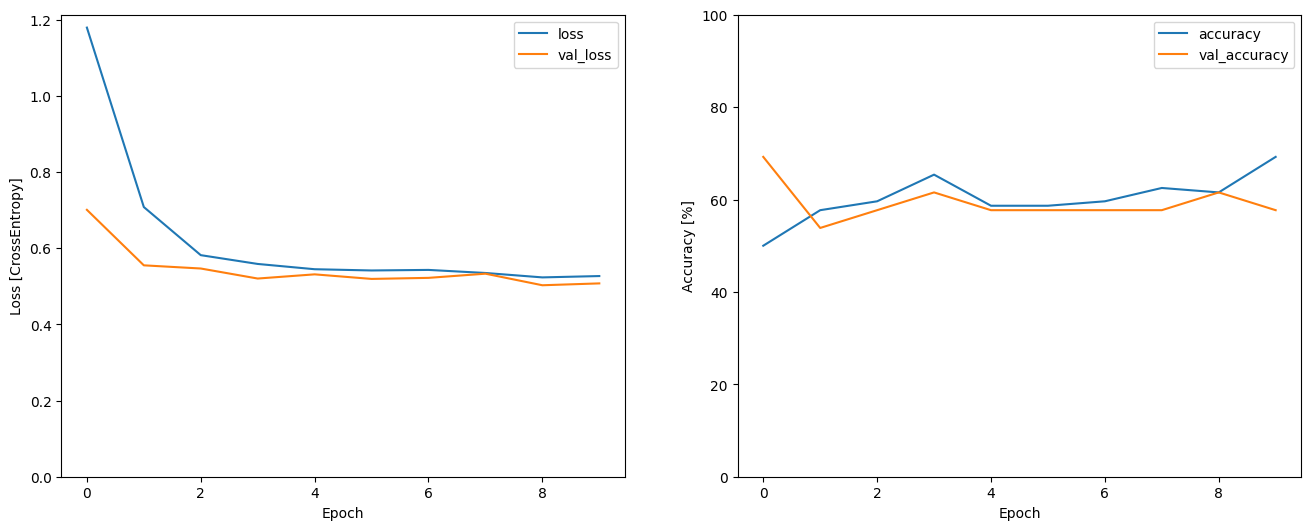

In [18]:
trained_history_spec_conv = trained_model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_spec_conv)

# Save models

In [19]:
trained_model_mfcc_seq.save('models/renf_mfcc_seq.h5')
trained_model_mfcc_conv.save('models/renf_mfcc_conv.h5')
trained_model_spec_seq.save('models/renf_spec_seq.h5')
trained_model_spec_conv.save('models/renf_spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Summary

In [20]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, VLoss: {history.history['val_loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f},  VAcc: {history.history['val_accuracy'][-1]:.2f}" )

print("=== RAW ===")
# history_to_summary("MFCCs + Seq       ", history_mfcc_seq)
history_to_summary("MFCCs + Conv      ", history_mfcc_conv)
# history_to_summary("Spectrogram + Seq ", history_spec_seq)
history_to_summary("Spectrogram + Conv", history_spec_conv)
print("")
print("=== TRAINED ===")
# history_to_summary("Tr. MFCCs + Seq       ", trained_history_mfcc_seq)
history_to_summary("Tr. MFCCs + Conv      ", trained_history_mfcc_conv)
# history_to_summary("Tr. Spectrogram + Seq ", trained_history_spec_seq)
history_to_summary("Tr. Spectrogram + Conv", trained_history_spec_conv)


=== RAW ===
MFCCs + Conv      :    Loss: 0.61, VLoss: 0.57, Acc: 0.82,  VAcc: 0.92
Spectrogram + Conv:    Loss: 0.51, VLoss: 0.51, Acc: 0.68,  VAcc: 0.65

=== TRAINED ===
Tr. MFCCs + Conv      :    Loss: 0.41, VLoss: 0.40, Acc: 0.81,  VAcc: 0.81
Tr. Spectrogram + Conv:    Loss: 0.53, VLoss: 0.51, Acc: 0.69,  VAcc: 0.58
